In [1]:
print("hello")

hello


In [2]:
import gradio as gr
from constants import DATASET_PATH, LABELS, IMAGE_FOLDER, CLOUD_FOLDER, API_URL
import pandas as pd
import subprocess
import os
import glob
import numpy as np
from PIL import Image
from pathlib import Path
import base64
from io import BytesIO
import requests
import json

# TEMP

In [ ]:
# Pick a few random images from each class (2 par classe soit 14 images)
df = pd.read_pickle(DATASET_PATH)
df_sampled = pd.concat([df[df["class"] == label].sample(2) for label in LABELS])
print(df_sampled.shape)

(14, 4)


In [ ]:
# Populate the image folders and add a constant path to this folder in constants.py
for i, row in df_sampled.iterrows():
    image_renamed = row["product_name"].replace("  ", "").strip().capitalize()
    df_sampled.at[i, "image_renamed"] = image_renamed
    subprocess.run(
        ["cp", IMAGE_FOLDER / row["image"], CLOUD_FOLDER / "images" / row["image"]]
    )

In [18]:
df_sampled.to_csv("sampled.csv", index=False)

# BLOCK DASHBOARD

In [3]:
df_dashboard = pd.read_pickle(DATASET_PATH)

In [4]:
images_name_dashboard = os.listdir(IMAGE_FOLDER)
images_path_dashboard = list(glob.glob(str(IMAGE_FOLDER / "*.jpg")))
assert len(images_name_dashboard) == len(images_path_dashboard)
len(images_path_dashboard)

1050

In [5]:
df_dashboard.head()

,product_name,image,description,class
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


In [6]:
df_dashboard["size"] = df_dashboard["image"].apply(
    lambda x: Image.open(IMAGE_FOLDER / x).size
)
df_dashboard["width"] = df_dashboard["size"].apply(lambda x: x[0])
df_dashboard["height"] = df_dashboard["size"].apply(lambda x: x[1])
df_dashboard.drop(columns=["size"], inplace=True)

/home/hedredo/github/oc_p9/frontend/.venv/lib/python3.11/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [7]:
# make a scatter plot with plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Draw a scatter plot with height and width from df_dashboard as x and y axis
fig = px.scatter(
    df_dashboard,
    x="width",
    y="height",
    color="class",
    hover_name="product_name",
    hover_data=["image"],
)
fig.update_traces(marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")))
fig.update_layout(
    title="Scatter plot of images",
    xaxis_title="Width",
    yaxis_title="Height",
    legend_title="Class",
)

# BLOCK CLASSIFIER

In [9]:
df = pd.read_csv("sampled.csv")
df.head(5)

,product_name,image,description,class,image_renamed
0,Boreal Plastic rectangular hair brush 633D,5ea8ddb8a5104c5d47c708e8a351e701.jpg,Specifications of Boreal Plastic rectangular h...,Baby Care,Boreal plastic rectangular hair brush 633d
1,Jacadi paris Baby Boy's Striped Casual Blue Shirt,4b500e244f11a45f5171bd3665413044.jpg,Key Features of Jacadi paris Baby Boy's Stripe...,Baby Care,Jacadi paris baby boy's striped casual blue shirt
2,RYTHMX FB NAIL POLISHES BLACK LIPSTICKS IMPORT...,5e84d36ad6db970548498829db8b15de.jpg,Specifications of RYTHMX FB NAIL POLISHES BLAC...,Beauty and Personal Care,Rythmx fb nail polishes black lipsticks import...
3,Anna Andre Paris Majesty Deodorant Combo Set,6e44d107ee32412243b19b0ed9b415f3.jpg,Flipkart.com: Buy Anna Andre Paris Majesty Deo...,Beauty and Personal Care,Anna andre paris majesty deodorant combo set
4,HP Compaq Presario CQ43 6 Cell Laptop Battery,9a8fa4fd6524ada03411b033a9daadc1.jpg,Buy HP Compaq Presario CQ43 6 Cell Laptop Batt...,Computers,Hp compaq presario cq43 6 cell laptop battery


In [10]:

files = os.listdir(CLOUD_FOLDER / "images")
filename2path = {filename: CLOUD_FOLDER / "images" / filename for filename in files}
id2filename = {
    df.loc[df["image"] == filename, "image_renamed"].values[0]: filename
    for filename in files
}

In [11]:
id2filename

{'Edimax br6524n n300 wireless router': '5c6b9db55291a68d99c4bb9a88266e27.jpg',
 'Home originals abstract, geometric double blanket multicolor': '841b14271aa4c29f291f600c9556145c.jpg',
 'Kosher kadhai 5 l': '7e4c1d31e279a700c6b8e66d820e8601.jpg',
 'Hp compaq presario cq43 6 cell laptop battery': '9a8fa4fd6524ada03411b033a9daadc1.jpg',
 'Sonata 8098ym01 analog watch- for women': '321f2ab0dd243778c87ac63ace6639f4.jpg',
 'Prithish believe in yourself double color ceramic mug': '02127f52e96fb72c66bf081d25104ef8.jpg',
 'Mavi 237mbb showpiece-15 cm': '7ee2e665b7de2e1cc29e3c65bde0c318.jpg',
 "Jacadi paris baby boy's striped casual blue shirt": '4b500e244f11a45f5171bd3665413044.jpg',
 'Lal haveli iron wall decorative musician showpiece-50.8 cm': 'be0e65c6d8c2cc8cb913b36aa4168cf0.jpg',
 'Fastrack 9912pp09 tees analog watch- for men, women': '8748b6cd9f03afc539f246c55e230502.jpg',
 'Boreal plastic rectangular hair brush 633d': '5ea8ddb8a5104c5d47c708e8a351e701.jpg',
 'Anna andre paris majesty de

In [12]:
def load_image(name: str) -> Path:
    """
    Load an image from the specified path.
    """
    filename = id2filename.get(name)
    filepath = filename2path.get(filename)
    return Image.open(filepath)

In [13]:
# Function to decode base64 string to image
def decode_base64_to_image(base64_str: str) -> Image.Image:
    image_bytes = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_bytes))


# Function to convert image to base64 string
def img_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [36]:
img = load_image("Anna andre paris majesty deodorant combo set")

In [37]:
img.size

(646, 1100)

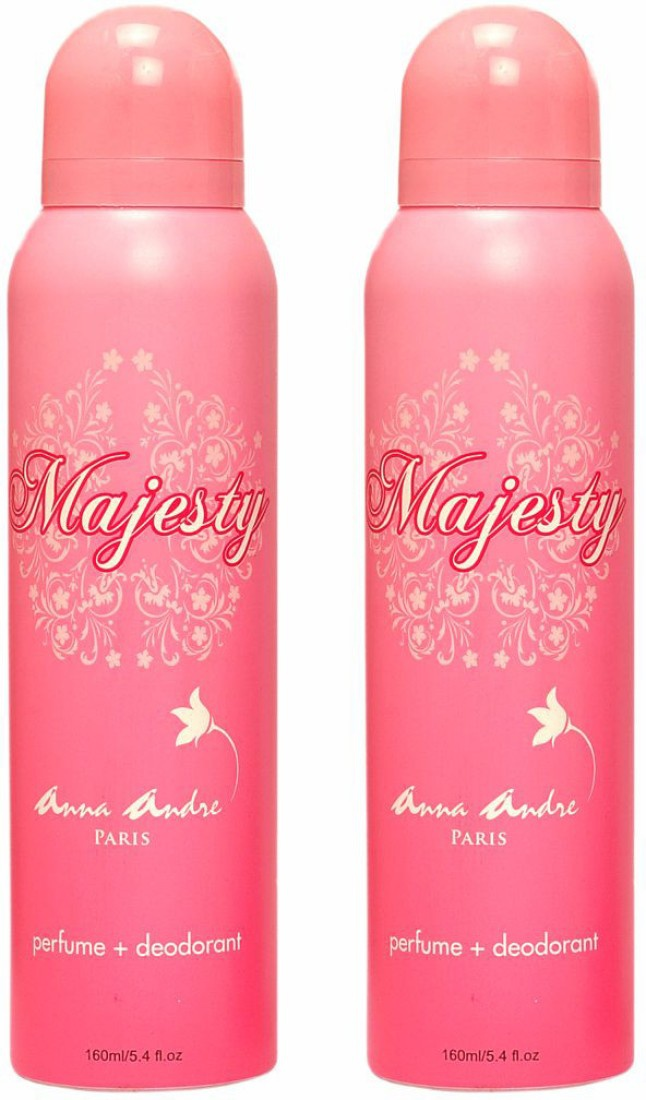

In [38]:
img.show()

In [39]:
img_b64 = img_to_base64(img)

In [40]:
type(img_b64)

str

In [14]:
def classify_image(image_name: str) -> str:
    """
    Predict the label of the image using a dummy model.
    """
    # Simulate a prediction
    img = load_image(image_name)
    img_b64 = img_to_base64(img)
    # Send the image to the API
    content = send_image_to_api(img_b64, "predict")
    # Extract the label from the response
    label = content.get("predicted_label", "Unknown")
    return label

In [15]:
# Create a request with the img_b64 as a payload to the API
def send_image_to_api(image_b64: str, endpoint: str, api_url: str = API_URL) -> str:
    url = f"{api_url}/{endpoint}/"
    headers = {"Content-Type": "application/json"}
    payload = json.dumps({"image": image_b64})
    response = requests.post(url, headers=headers, data=payload)
    return response.json()

In [41]:
response = send_image_to_api(img_b64, "predict", api_url=API_URL)

In [42]:
response

{'predicted_label': 'Beauty and Personal Care',
 'probabilities': {'Baby Care': 0.01,
  'Beauty and Personal Care': 0.96,
  'Computers': 0.01,
  'Home Decor & Festive Needs': 0.0,
  'Home Furnishing': 0.01,
  'Kitchen & Dining': 0.0,
  'Watches': 0.01}}

In [19]:
response = send_image_to_api(img_b64, "normalize", api_url=API_URL)

In [20]:
img_nm = decode_base64_to_image(response["image_normalized"])
img_nm.size

(224, 224)

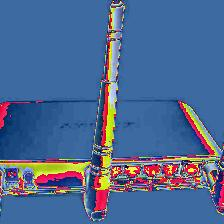

In [21]:
img_nm.show()

In [ ]:
# Gradio code pour l'interface utilisateur
with gr.Blocks(
    css="#image_input {border: 2px solid #ccc;}",
    # TODO : Eventuellement modifier le tooltip de l'image par sa description ?
    js="""
    () => {
        setTimeout(() => {
            // Tooltip pour l'image
            const img = document.querySelector('#image_input img');
            if (img) {
                img.title = "image à classifier";
            }
            // Tooltip pour bloc avec la catégorie prédite
            const label = document.querySelector('#image_label');
            if (label) {
                label.title = "Catégorie prédite";
            }
            // Tooltip pour le bouton "Classifier l'image"
            const btns = document.querySelectorAll('button');
            btns.forEach(btn => {
                if (btn.innerText.trim() === "Classifier l'image") {
                    btn.setAttribute('title', "Classifier l'image");
                }
            });
        }, 500);
    }
    """
) as demo:
    # Application title. TODO : Ajouter la description de l'app
    gr.Markdown(
        """
        <h1 style="text-align: center; color: #4CAF50;">Mon App</h1>
        """,
        elem_id="title",  # ID pour le CSS
        elem_classes="title",  # Classes CSS pour le style
    )
    #####################
    # Classifier tab  #
    #####################
    with gr.Tab("Classification"):
        gr.Markdown(
            """
            <h2 style="text-align: left;">Interface applicative pour utiliser le modèle de classification d'image.</h2>
            <p style="text-align: left;">Instructions ...</p>
            """,
            elem_id="classifier_title",  # ID pour le CSS
            elem_classes="classifier-title",  # Classes CSS pour le style
        )
        # List of images to classify
        with gr.Row():
            dropdown = gr.Dropdown(
                label="Choisissez un produit dans la liste déroulante à afficher",
                choices=list(id2filename.keys()),  # Liste des labels
                value=list(id2filename.keys())[0],  # Valeur par défaut
            )
        # Block to display the image and the predicted label
        with gr.Row():
            image_input = gr.Image(
                value=list(filename2path.values())[0],
                type="filepath",
                label="Image à classifier",
                elem_id="image_input",  # ID pour le CSS
                elem_classes="image-input",  # Classes CSS pour le style
                height=256,
                width=256,
            )
            image_label = gr.Label(
                label="Catégorie prédite",
                elem_id="image_label",  # ID pour le CSS
                elem_classes="image-label",  # Classes CSS pour le style
            )

            # Charger l'exemple sélectionné
            dropdown.change(fn=load_image, inputs=dropdown, outputs=image_input)
        # Button to launch the classification
        with gr.Row():
            # Bouton pour lancer la segmentation
            submit_btn = gr.Button("Classifier l'image")
            submit_btn.click(classify_image, inputs=dropdown, outputs=[image_label])

    #################
    # Dashboard tab #
    #################
    with gr.Tab("Dashboard"):
        gr.Markdown(
            """
            <h2 style="text-align: left;">Dashboard de présentation du dataset Flipkart.</h2>
            <p style="text-align: left;">Instructions ...</p>
            """,
            elem_id="dashboard_title",  # ID pour le CSS
            elem_classes="dashboard-title",  # Classes CSS pour le style
        )
        gr.Plot(
            value=fig,
            label="Scatterplot des tailles d'images",
            elem_id="scatterplot_dashboard"
        )
        # TODO : Ajouter un dashboard avec des graphiques et des statistiques

demo.launch(inline=False)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
